In [3]:
file_path = 'paris_temperature.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

In [4]:
# ex5

import optuna
import lightgbm as lgb
import logging

data['datetime'] = pd.to_datetime(data['datetime'])
data = data.sort_values(by='datetime')

# Step 2: Define train-test split based on the date ranges from Question 4
train_data = data[(data['datetime'] >= '2023-10-01') & (data['datetime'] <= '2024-09-15')]
test_data = data[data['datetime'] > '2024-09-15']

# Step 3: Select features and target variable
numerical_features = ['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'dew', 'humidity',
                      'precip', 'precipprob', 'windspeed', 'cloudcover', 'visibility',
                      'solarradiation', 'solarenergy', 'uvindex', 'moonphase']
target = 'temp'

X_train = train_data[numerical_features]
y_train = train_data[target]
X_test = test_data[numerical_features]
y_test = test_data[target]


# Enable logging
logging.basicConfig(level=logging.INFO)
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    # Define the parameter space
    param = {
        'objective': 'regression',
        'metric': 'root_mean_squared_error',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    # Create LightGBM datasets
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # Manual early stopping
    num_boost_round = 1000
    best_iteration = 0
    min_rmse = float('inf')
    early_stopping_rounds = 50

    for i in range(1, num_boost_round + 1):
        # Train the model incrementally
        gbm = lgb.train(param, lgb_train, num_boost_round=i, valid_sets=[lgb_valid])
        y_pred = gbm.predict(X_test, num_iteration=i)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        
        # Update best iteration and RMSE
        if rmse < min_rmse:
            min_rmse = rmse
            best_iteration = i
        elif i - best_iteration >= early_stopping_rounds:
            break  # Stop if no improvement for early_stopping_rounds
    
    # Save best_iteration in the study
    trial.study.set_user_attr("best_iteration", best_iteration)
    
    # Log the best iteration and corresponding RMSE
    logging.info(f"Best iteration: {best_iteration}, RMSE: {min_rmse}")
    
    return min_rmse

# Step 2: Initialize Optuna study and optimize
study = optuna.create_study(direction='minimize', study_name='LGBM Regressor Optimization')
study.optimize(objective, n_trials=10)

# Step 3: Get the best parameters and best iteration
best_params = study.best_params
best_iteration = study.user_attrs["best_iteration"]  # Retrieve best iteration

print("Best hyperparameters:", best_params)
print("Best iteration:", best_iteration)

# Step 4: Train the final model with the best parameters
best_params['objective'] = 'regression'
best_params['metric'] = 'root_mean_squared_error'

final_model = lgb.train(
    best_params,
    lgb.Dataset(X_train, y_train),
    valid_sets=[lgb.Dataset(X_test, y_test)],
    num_boost_round=best_iteration  # Use the best iteration
)

# Step 5: Make predictions and evaluate the final model
# Step 5: Make predictions and evaluate the final model
y_pred_final = final_model.predict(X_test, num_iteration=best_iteration)

# Metrics Calculation
mae = mean_absolute_error(y_test, y_pred_final)
mse = mean_squared_error(y_test, y_pred_final)
rmse = mean_squared_error(y_test, y_pred_final, squared=False)
r2 = r2_score(y_test, y_pred_final)

# Print the metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


[I 2024-11-22 16:02:37,968] A new study created in memory with name: LGBM Regressor Optimization
/var/folders/2w/b69fgcpn1zx112dnyw7889rh0000gn/T/ipykernel_8161/2646781462.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/var/folders/2w/b69fgcpn1zx112dnyw7889rh0000gn/T/ipykernel_8161/2646781462.py:38: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/var/folders/2w/b69fgcpn1zx112dnyw7889rh0000gn/T/ipykernel_8161/2646781462.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:

Best hyperparameters: {'lambda_l1': 0.0001524887174587507, 'lambda_l2': 0.010720287260213845, 'num_leaves': 46, 'learning_rate': 0.05356179278971922, 'max_depth': 12, 'feature_fraction': 0.7642426180710381, 'bagging_fraction': 0.9819707805895235, 'bagging_freq': 6, 'min_child_samples': 23}
Best iteration: 115
MAE: 0.3088
MSE: 0.1554
RMSE: 0.3942
R2 Score: 0.9837


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

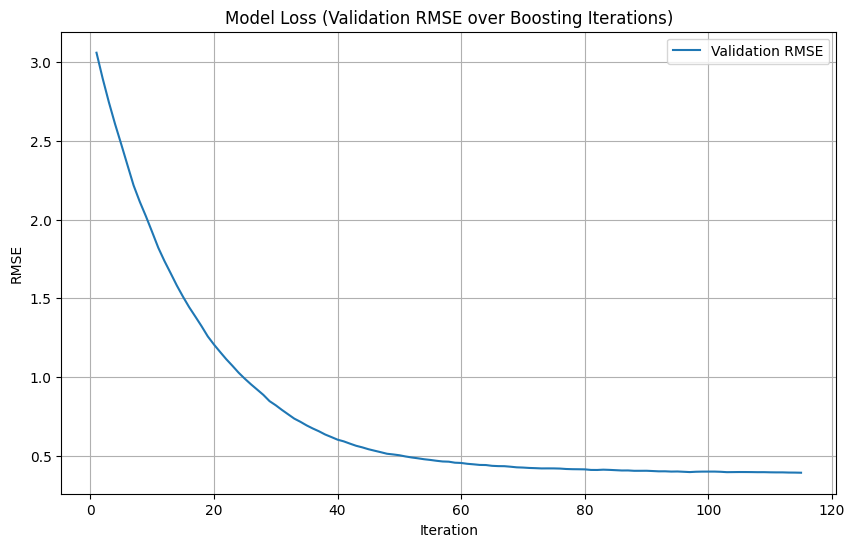

In [ ]:
# Plot 1: Model Loss (Validation RMSE over Boosting Iterations)

# Train the final model and collect validation loss manually
validation_loss = []
for i in range(1, best_iteration + 1):
    y_pred_partial = final_model.predict(X_test, num_iteration=i)
    rmse_partial = mean_squared_error(y_test, y_pred_partial, squared=False)
    validation_loss.append(rmse_partial)

# Plot the validation RMSE over iterations
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, best_iteration + 1), validation_loss, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Model Loss (Validation RMSE over Boosting Iterations)')
plt.legend()
plt.grid(True)
plt.show()


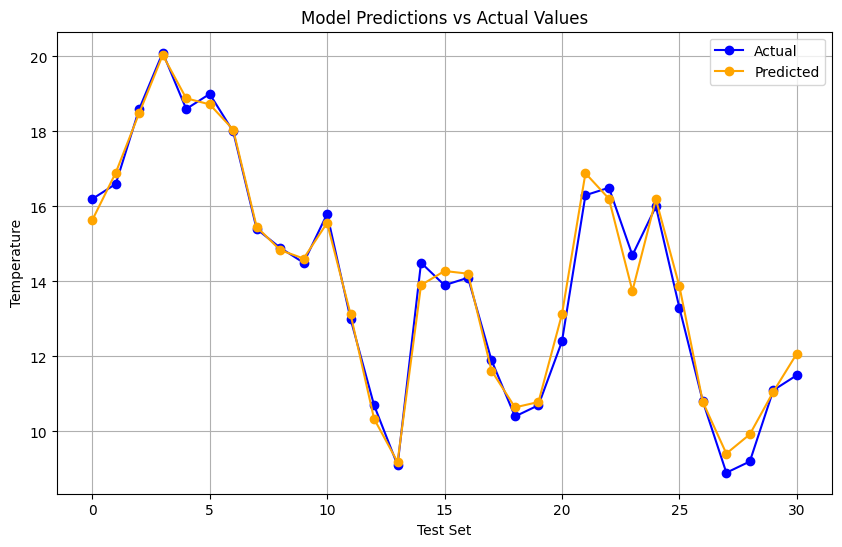

In [11]:
# Plot 2: Predicted vs Actual Values (Line Chart)
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(range(len(y_test)), y_test, label='Actual', color='blue', marker='o', linestyle='-')

# Plot predicted values
plt.plot(range(len(y_pred_final)), y_pred_final, label='Predicted', color='orange', marker='o', linestyle='-')

# Add labels, title, and legend
plt.xlabel('Test Set')
plt.ylabel('Temperature')
plt.title('Model Predictions vs Actual Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
